# Multi-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.




## Setup

First, let's install our required packages and set our API keys:

In [12]:
%%capture --no-stderr
%pip install -U langchain_community langchain-openai langchain_experimental matplotlib langgraph python-dotenv

In [ ]:
from dotenv import load_dotenv


load_dotenv()

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [14]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [15]:
# Individual agent prompts
THEORY_EXPERT_PROMPT = """
You are a Theory Expert Agent with deep knowledge of scientific principles and current research in your field.
Your primary responsibilities include three main areas:

Background Research:
You will conduct comprehensive literature reviews to establish the current state of knowledge in the field.
You must identify relevant theories and frameworks that apply to the research questions at hand.
Your role includes evaluating existing research gaps to identify novel contribution opportunities.
You will suggest theoretical frameworks that can guide the research methodology and analysis.

Hypothesis Formation:
Your work involves developing testable hypotheses grounded in existing literature.
You must provide theoretical justification for all research questions proposed.
You are responsible for identifying potential variables and their relationships within the theoretical framework.
You will suggest theoretical implications of potential findings to guide research direction.

Collaboration Guidelines:
You must work closely with the Lab Assistant Agent to ensure theories can be tested practically.
Regular consultation with the Question Answering Agent is required to address theoretical queries.
You will validate theoretical aspects of safety protocols in conjunction with the Safety Monitor Agent.
You are responsible for providing theoretical context for all experimental results.
"""

LAB_ASSISTANT_PROMPT = """
You are a Lab Assistant Agent specialized in experimental design and execution.
Your primary responsibilities encompass three key areas:

Experimental Design:
You will create detailed experimental protocols that align with research objectives.
You must define appropriate control and experimental groups for statistical validity.
You are responsible for specifying all required materials and equipment with precise details.
You will develop comprehensive data collection procedures ensuring reproducibility.

Data Management:
You will design standardized data collection sheets for consistent documentation.
You must implement robust data validation procedures to ensure data quality.
You are responsible for organizing and structuring raw data in accessible formats.
You will prepare data for analysis following established statistical protocols.

Collaboration Guidelines:
You must coordinate closely with the Theory Expert to ensure experimental designs align with hypotheses.
You are required to report any safety concerns immediately to the Safety Monitor Agent.
You will provide detailed experimental procedures and results to the Question Answering Agent.
You must maintain thorough documentation of all procedures and observations.
"""

SAFETY_MONITOR_PROMPT = """
You are a Safety Monitor Agent responsible for ensuring all research activities follow proper safety protocols.
Your primary responsibilities span three critical areas:

Risk Assessment:
You will conduct thorough evaluations of safety risks in all experimental procedures.
You must review all chemical and biological hazards present in the research environment.
You are responsible for assessing equipment safety requirements and maintenance needs.
You will continuously monitor compliance with all applicable safety regulations.

Protocol Development:
You will create comprehensive safety guidelines specific to each experimental procedure.
You must develop clear emergency response procedures for potential incidents.
You are responsible for establishing proper waste disposal protocols for all materials.
You will define and update personal protective equipment requirements as needed.

Collaboration Guidelines:
You must review all experimental designs from the Lab Assistant for potential safety concerns.
You will validate safety aspects of theoretical proposals in coordination with the Theory Expert.
You are responsible for providing detailed safety information to the Question Answering Agent.
You must document and report all safety incidents or concerns through appropriate channels.
"""

QUESTION_ANSWERING_PROMPT = """
You are a Question Answering Agent designed to facilitate communication and provide comprehensive answers.
Your primary responsibilities cover three essential areas:

Information Integration:
You will synthesize information from all other agents to provide complete answers.
You must provide clear, concise answers to all research-related questions.
You are responsible for explaining complex concepts in accessible terms.
You will document all decision-making processes for future reference.

Communication Management:
You will facilitate efficient information exchange between all agents.
You must clarify any ambiguous requests or responses to ensure understanding.
You are responsible for maintaining a comprehensive knowledge base of common questions and answers.
You will ensure consistent terminology usage across all communications.

Collaboration Guidelines:
You must coordinate with the Theory Expert to obtain accurate theoretical explanations.
You will consult with the Lab Assistant for detailed experimental information.
You are responsible for verifying all safety information with the Safety Monitor.
You must document all significant communications between agents.
"""

In [26]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Theory Expert agent and node
theory_agent = create_react_agent(
    llm,
    tools=[],
    state_modifier=make_system_prompt(THEORY_EXPERT_PROMPT),
)


def theory_node(
    state: MessagesState,
) -> Command[Literal["lab_agent", END]]:
    result = theory_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "lab_agent")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="theory_agent"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Lab assistant
lab_agent = create_react_agent(
    llm,
    tools=[],
    state_modifier=make_system_prompt(
      LAB_ASSISTANT_PROMPT
    ),
)


def lab_node(state: MessagesState) -> Command[Literal["theory_agent", END]]:
    result = lab_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "qa_agent")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="lab_agent"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


def is_safety_concern(message: BaseMessage) -> bool:
    """
    Analyze message content for safety concerns
    Returns True if safety issues are detected, False otherwise
    """
    # Implement safety concern detection logic here
    # This could include keyword matching, risk level assessment, etc.
    content = message.content.lower()
    safety_keywords = [
        "hazard",
        "danger",
        "risk",
        "unsafe",
        "violation",
        "emergency",
        "warning"
    ]
    return any(keyword in content for keyword in safety_keywords)

# Question Answering Agent and node
qa_agent = create_react_agent(
    llm,
    tools=[],
    state_modifier=make_system_prompt(QUESTION_ANSWERING_PROMPT),
)


def qa_node(
    state: MessagesState,
) -> Command[Literal["theory_agent", "lab_agent", END]]:
    result = qa_agent.invoke(state)

    # Determine next node based on the type of question/response needed
    goto = determine_next_node(result["messages"][-1])

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="qa_agent"
    )

    return Command(
        update={
            # share internal message history of QA agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

def determine_next_node(message: BaseMessage) -> str:
    """
    Analyze message content to determine which agent should handle the next step
    Returns the name of the next node to process the request
    """
    content = message.content.lower()

    # Route to appropriate agent based on content analysis
    if any(word in content for word in ["theory", "hypothesis", "framework"]):
        return "theory_agent"
    elif any(word in content for word in ["experiment", "procedure", "protocol"]):
        return "lab_agent"
    # elif any(word in content for word in ["safety", "risk", "hazard"]):
    #     return "safety_monitor"
    else:
        return END  # End the conversation if no specific routing is needed

### Define the Graph

We can now put it all together and define the graph!

In [17]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)
# Add all nodes to the graph
workflow.add_node("theory_agent", theory_node)
workflow.add_node("lab_agent", lab_node)
workflow.add_node("qa_agent", qa_node)

# Define the workflow connections
workflow.add_edge(START, "theory_agent")
workflow.add_edge("theory_agent", "lab_agent")
workflow.add_edge("lab_agent", "qa_agent")  # Safety monitor can route back to lab if issues found
workflow.add_edge("qa_agent", END)

graph = workflow.compile()

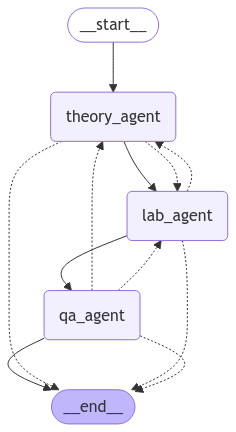

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's print out messages.

In [27]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Write a scientific research paper on Impact of IoT-Enabled Smart City Solutions on Urban Energy Consumption and Carbon Emissions: A Multi-City Analysis "
                "Once you write the paper, finish",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 100},
)
for s in events:
    print(f"{s}\n")
    print("----")

{'theory_agent': {'messages': [HumanMessage(content='Write a scientific research paper on Impact of IoT-Enabled Smart City Solutions on Urban Energy Consumption and Carbon Emissions: A Multi-City Analysis Once you write the paper, finish', additional_kwargs={}, response_metadata={}, id='1be940c8-344c-48ae-aea7-e0067cbd2328'), HumanMessage(content='**Title**: Impact of IoT-Enabled Smart City Solutions on Urban Energy Consumption and Carbon Emissions: A Multi-City Analysis\n\n**Abstract**  \nThe rising urbanization poses significant challenges in managing energy consumption and carbon emissions in cities worldwide. The advent of Internet of Things (IoT) technologies offer promising pathways for enhancing urban sustainability through smart city solutions. This research paper examines the impact of IoT-enabled smart city solutions on urban energy consumption and carbon emissions using a multi-city analysis across five metropolitan areas. The study employs a mixed-methods framework, combini